# Analysis of the final catalogue of matched sources

We will analyse the changes in the classification using the new sigma and the new catalogue without the galaxies that went to LGZ

## Configuration

### Load libraries and setup

In [1]:
import numpy as np
from astropy.table import Table, join
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
import pickle
import os

In [2]:
from mltier1 import (get_center, get_n_m, estimate_q_m, Field, MultiMLEstimatorU,
                     parallel_process, get_sigma_all, get_q_m, describe)

In [3]:
%load_ext autoreload

In [4]:
%autoreload

In [5]:
from IPython.display import clear_output

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
def most_common(a, n=2):
    u, c = np.unique(a, return_counts=True)
    order = np.argsort(c)
    for i in range(n):
        print(c[order][-(i+1)], u[order][-(i+1)])

### General configuration

In [8]:
save_intermediate = True
plot_intermediate = True

In [9]:
idp = "idata/final_analysis"

In [10]:
if not os.path.isdir(idp):
    os.makedirs(idp)

## Load data

In [11]:
pwli = Table.read("lofar_pw_test.fits")

In [12]:
pwli.colnames

['Source_Name',
 'RA',
 'E_RA',
 'DEC',
 'E_DEC',
 'Peak_flux',
 'E_Peak_flux',
 'Total_flux',
 'E_Total_flux',
 'Maj',
 'E_Maj',
 'Min',
 'E_Min',
 'PA',
 'E_PA',
 'Isl_rms',
 'S_Code',
 'Mosaic_ID',
 'AllWISE',
 'objID',
 'ra',
 'dec',
 'raErr',
 'decErr',
 'W1mag',
 'W1magErr',
 'i',
 'iErr',
 'colour',
 'category',
 'lr',
 'lr_dist',
 'AllWISE_input',
 'objID_input',
 'ML_LR',
 'match_code']

In [13]:
pwlit = Table.read("lofar_pw.fits")

In [14]:
pwlit.colnames

['Source_Name',
 'RA',
 'E_RA',
 'DEC',
 'E_DEC',
 'Peak_flux',
 'E_Peak_flux',
 'Total_flux',
 'E_Total_flux',
 'Maj',
 'E_Maj',
 'Min',
 'E_Min',
 'PA',
 'E_PA',
 'Isl_rms',
 'S_Code',
 'Mosaic_ID',
 'AllWISE',
 'objID',
 'ra',
 'dec',
 'raErr',
 'decErr',
 'W1mag',
 'W1magErr',
 'i',
 'iErr',
 'colour',
 'category',
 'lr',
 'lr_dist']

In [15]:
lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_merge_ID_optical_v0.7.fits")

#### Join data tables

In [16]:
pwl = join(pwli, lofar_all[['Source_Name', 'AllWISE', 'objID', 'ML_LR', 
                            'ID_flag', 'ID_name', 'ID_ra', 'ID_dec', 
                            'LGZ_Size', 'LGZ_Width', 'LGZ_PA', 'LGZ_Assoc', 
                            'LGZ_Assoc_Qual', 'LGZ_ID_Qual']], 
           join_type='left', 
           keys='Source_Name', 
           uniq_col_name='{col_name}{table_name}', 
           table_names=['', '_v07'])

In [17]:
colour_limits = [0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0]

In [18]:
bin_list, centers, Q_0_colour, n_m, q_m = pickle.load(open("lofar_params.pckl", "rb"))

In [19]:
def smooth(a):
    g=np.gradient(a)
    return np.nanmean(g.reshape(len(g)//10, 10), axis=1)

/disk2/jsm/prog/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/disk2/jsm/prog/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


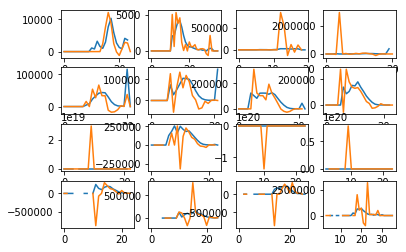

In [20]:
for i in range(16):
    subplot(4,4,i+1)
    plot(smooth(q_m[i])/smooth(n_m[i]))
    plot(smooth(np.gradient(q_m[i]))/smooth(np.gradient(n_m[i])))

In [112]:
from astropy.stats import bayesian_blocks

In [113]:
bayesian_blocks(np.gradient(q_m[10]))

array([  0.00000000e+00,   5.63563330e-05,   1.12712667e-04,
         1.12714165e-04,   1.12714166e-04,   2.25425334e-04,
         2.25428331e-04,   2.25428333e-04,   3.38142498e-04,
         3.38142499e-04,   4.50856664e-04,   4.50856665e-04,
         5.63570830e-04,   5.63570831e-04,   6.76284252e-04,
         6.76284995e-04,   6.76284997e-04,   1.12714018e-03,
         1.12714166e-03,   3.04327981e-03,   3.04327989e-03,
         7.21370460e-03,   7.21370664e-03,   3.12218239e-02])

#### Explore and repair data

In [63]:
for col in pwl.colnames:
    fv = pwl[col].fill_value
    typ = pwl[col].dtype
    print(col, fv, typ)
    # Restore NaNs
    if fv == 1e+20:
        pwl[col][(pwl[col] == fv)] = np.nan
#     if (isinstance(fv, np.float64) and (fv != 1e+20)):
#         print(col, fv)
#         pwl[col].fill_value = 1e+20

Source_Name N/A <U88
RA 1e+20 >f8
E_RA 1e+20 >f8
DEC 1e+20 >f8
E_DEC 1e+20 >f8
Peak_flux 1e+20 >f8
E_Peak_flux 1e+20 >f8
Total_flux 1e+20 >f8
E_Total_flux 1e+20 >f8
Maj 1e+20 >f8
E_Maj 1e+20 >f8
Min 1e+20 >f8
E_Min 1e+20 >f8
PA 1e+20 >f8
E_PA 1e+20 >f8
Isl_rms 1e+20 >f8
S_Code N <U1
Mosaic_ID N/A <U9
AllWISE N/A <U19
objID 999999 >i8
ra 1e+20 >f8
dec 1e+20 >f8
raErr 1e+20 >f8
decErr 1e+20 >f8
W1mag 1e+20 >f8
W1magErr 1e+20 >f8
i 1e+20 >f8
iErr 1e+20 >f8
colour 1.0 >f8
category 1e+20 >f8
lr 1.0 >f8
lr_dist 1e+20 >f8
AllWISE_input N/A <U19
objID_input 999999 >i8
ML_LR 1.0 >f8
match_code 1 >i8
AllWISE_v07 N/A <U19
objID_v07 999999 >i8
ML_LR_v07 1e+20 >f8
ID_flag 999999 >i8
ID_name N/A <U26
ID_ra 1e+20 >f8
ID_dec 1e+20 >f8
LGZ_Size 1e+20 >f8
LGZ_Width 1e+20 >f8
LGZ_PA 1e+20 >f8
LGZ_Assoc 1e+20 >f8
LGZ_Assoc_Qual 1e+20 >f8
LGZ_ID_Qual 1e+20 >f8


In [22]:
describe(pwl["match_code"])

1.935 +/- 1.766; median: 1.000; limits: [0.000, 5.000]; N=321817 (0 NaN; 0 masked)


/disk2/jsm/prog/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [65]:
pwl["colour"][(pwl["colour"] == 1e+20)] = np.nan

In [66]:
describe(pwl["colour"])

2.125 +/- 0.814; median: 2.065; limits: [-1.781, 12.210]; N=321817 (172256 NaN; 0 masked)


/disk2/jsm/prog/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:4125: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  part.partition(kth)


Change the AllWISE_input that are '' to 'N/A'. That comes from a previous error with the fill value.

In [23]:
pwl["AllWISE_input"][pwl["AllWISE_input"] == ""] = "N/A"

### Create the additional columns for the types of matches

In [34]:
cond_mlr = (pwl['ID_flag'] == 1) & (pwl['Maj'] < 30.)

/disk2/jsm/prog/anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)


In [35]:
pwlaux = pwl[cond_mlr].filled()

Matched sources

In [36]:
pwlaux_match = pwlaux[~np.isnan(pwlaux['ML_LR'])]

In [37]:
len(pwlaux_match)

219133

In [38]:
cond_match = (
    ~np.isnan(pwlaux_match['lr']) &
    (pwlaux_match['lr'] >= threshold_sel) &
    (
        (pwlaux_match["AllWISE_input"] != "N/A") |
         ~np.isnan(pwlaux_match['objID_input'])
    ) &
    (
        ( 
            (pwlaux_match["AllWISE"] == pwlaux_match["AllWISE_input"]) &
            (pwlaux_match["objID"] == pwlaux_match["objID_input"]) &
            ~np.isnan(pwlaux_match["objID"]) &
            (pwlaux_match["AllWISE"] != "N/A")
        ) |
        ( 
            (pwlaux_match["AllWISE"] == pwlaux_match["AllWISE_input"]) &
            np.isnan(pwlaux_match["objID"])
        ) |
        ( 
            (pwlaux_match["AllWISE"] == "N/A") &
            (pwlaux_match["objID"] == pwlaux_match["objID_input"])
        )
    )
        
)
m_m = np.sum(cond_match)
print(m_m)

217820


In [39]:
cond_diffmatch = (
    ~np.isnan(pwlaux_match['lr']) &
    (pwlaux_match['lr'] >= threshold_sel) &
    (
        (pwlaux_match["AllWISE_input"] != "N/A") |
         ~np.isnan(pwlaux_match['objID_input'])
    ) &
    (
        ( 
            (pwlaux_match["AllWISE"] != pwlaux_match["AllWISE_input"]) |
            (pwlaux_match["objID"] != pwlaux_match["objID_input"])
        ) 
    )

)
m_dm = np.sum(cond_diffmatch)
print(m_dm)

331


In [40]:
cond_nomatch = (
    np.isnan(pwlaux_match['lr']) |
    (pwlaux_match['lr'] < threshold_sel)
)
m_nm = np.sum(cond_nomatch)
print(m_nm)

985


In [41]:
m_nm + m_dm + m_m

219136

Non-matched sources

In [42]:
pwlaux_nomatch = pwlaux[np.isnan(pwlaux['ML_LR'])]

In [43]:
len(pwlaux_nomatch)

81490

In [44]:
cond2_match = (
    ~np.isnan(pwlaux_nomatch['lr']) &
    (pwlaux_nomatch['lr'] >= threshold_sel)   
)
m2_m = np.sum(cond2_match)
print(m2_m)

6183


/disk2/jsm/prog/anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, oper)(other)


In [45]:
cond2_nomatch = (
    np.isnan(pwlaux_nomatch['lr']) |
    (pwlaux_nomatch['lr'] < threshold_sel)
)
m2_nm = np.sum(cond2_nomatch)
print(m2_nm)

75307


/disk2/jsm/prog/anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)


In [46]:
m2_nm + m2_m

81490

In [47]:
m2_nm + m2_m + m_nm + m_dm + m_m

300626

Diagnostic columns

In [48]:
pwl['match_code'] = 0

In [49]:
pwl['match_code'][np.isin(pwl["Source_Name"], pwl[cond_mlr & ~np.isnan(pwl['ML_LR'])][cond_diffmatch]["Source_Name"])] = 2

In [50]:
pwl['match_code'][np.isin(pwl["Source_Name"], pwl[cond_mlr & ~np.isnan(pwl['ML_LR'])][cond_match]["Source_Name"])]=1

In [51]:
pwl['match_code'][np.isin(pwl["Source_Name"], pwl[cond_mlr & ~np.isnan(pwl['ML_LR'])][cond_nomatch]["Source_Name"])] = 3

In [52]:
pwl['match_code'][np.isin(pwl["Source_Name"], pwl[cond_mlr & np.isnan(pwl['ML_LR'])][cond2_match]["Source_Name"])] = 4

In [53]:
pwl['match_code'][np.isin(pwl["Source_Name"], pwl[cond_mlr & np.isnan(pwl['ML_LR'])][cond2_nomatch]["Source_Name"])] = 5

In [54]:
for i in range(6):
    print(i, np.sum(pwl['match_code'] == i))

0 21194
1 217820
2 328
3 985
4 6183
5 75307


### Study the 3 repeated sources

3 sources that are in group 1 and 2

In [231]:
pwl['match_code2'] = 0
pwl['match_code2'][np.isin(pwl["Source_Name"], pwl[cond_mlr & ~np.isnan(pwl['ML_LR'])][cond_match]["Source_Name"])]=1

In [249]:
t = pwl[np.isin(pwl["Source_Name"], pwl[cond_mlr & ~np.isnan(pwl['ML_LR'])][cond_diffmatch]["Source_Name"])]
t[t['match_code2'] != 0][['Source_Name', "AllWISE", "AllWISE_input", "objID", "objID_input"]]

Source_Name,AllWISE,AllWISE_input,objID,objID_input
str22,str19,str19,int64,int64
ILTJ105150.16+472306.9,N/A,J105150.11+472306.4,164861629587942860,164861629587942860
ILTJ131700.45+490748.4,N/A,J131700.38+490748.1,166951992516796699,166951992516796699
ILTJ124446.75+545233.0,N/A,J124446.79+545232.8,173851911952891597,173851911952891597


In [251]:
combined_all[combined_all["objID"] == 164861629587942860]

AllWISE,objID,ra,dec,raErr,decErr,W1mag,W1magErr,i,iErr
str19,int64,float64,float64,float64,float64,float64,float64,float64,float64
N/A,164861629587942860,162.95880637,47.38512028,0.0451599992812,0.0261400006711,nan,nan,18.5082593446,0.0200500003994
J105150.11+472306.4,164861629587942860,162.95880637,47.38512028,0.0451599992812,0.0261400006711,14.7576547452,0.023,13.5549588685,0.000216999993427


## Analyse changes in the matches

In [55]:
most_common(pwl["AllWISE_input"].filled(), n=10)

107148 N/A
2 J150913.19+523142.4
2 J140536.92+532745.1
2 J133258.25+535355.3
2 J121331.83+545238.1
2 J150800.29+531158.9
2 J115859.66+495922.9
2 J142623.22+485841.3
2 J135014.80+560232.9
2 J142013.63+460945.6


Save data for tests

In [56]:
np.sum(~np.isnan(pwl["colour"]) & (pwl["match_code"] == 3))

984

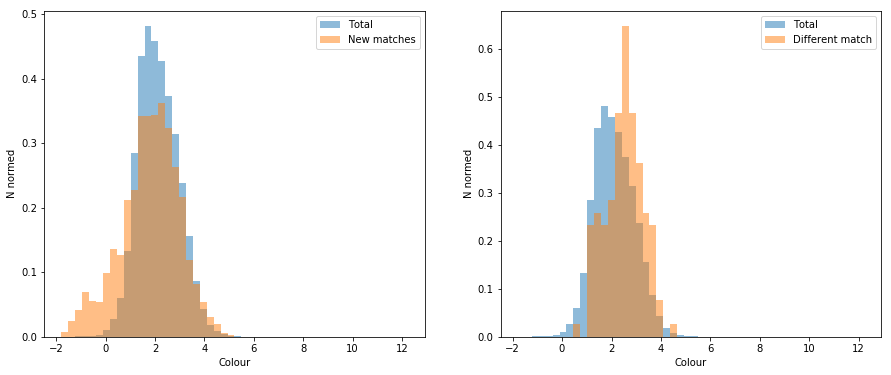

In [68]:
subplot(1,2,1)
val, bins, _ = hist(pwl["colour"][~np.isnan(pwl["colour"]) & (pwl["match_code"] != 0)], 
                    bins=50, normed=True, alpha=0.5, label="Total")
val, bins, _ = hist(pwl["colour"][~np.isnan(pwl["colour"]) & (pwl["match_code"] == 4)], 
                    bins=bins, normed=True, alpha=0.5, label="New matches")
xlabel("Colour")
ylabel("N normed")
legend()
subplot(1,2,2)
val, bins, _ = hist(pwl["colour"][~np.isnan(pwl["colour"]) & (pwl["match_code"] != 0)], 
                    bins=bins, normed=True, alpha=0.5, label="Total")
val, bins, _ = hist(pwl["colour"][~np.isnan(pwl["colour"]) & (pwl["match_code"] == 2)], 
                    bins=bins, normed=True, alpha=0.5, label="Different match")
xlabel("Colour")
ylabel("N normed")
legend()

## Additional description of the data

In [135]:
describe(pwlaux['ML_LR'])

513.503 +/- 678.560; median: 249.851; limits: [1.291, 5209.663]; N=224451 (6297 NaN; 0 masked)


In [136]:
describe(pwlaux['lr'])

1028.833 +/- 1267.626; median: 547.459; limits: [0.334, 8624.676]; N=224451 (0 NaN; 0 masked)


In [122]:
len(pwlaux)

300623

In [123]:
np.sum(
    (pwlaux["AllWISE"] != pwlaux["AllWISE_input"]) |
    (pwlaux["objID"] != pwlaux["objID_input"])  
      )

82801

In [125]:
np.sum(
    (pwlaux["AllWISE"] != pwlaux["AllWISE_input"]) &
    (pwlaux["objID"] != pwlaux["objID_input"])  
      )

4806

In [120]:
np.sum(
    (pwl[cond_mlr].filled()["AllWISE"] != pwl[cond_mlr]["AllWISE_input"]) &
    (pwl[cond_mlr].filled()["objID"] == pwl[cond_mlr]["objID_input"])  
      )

96

In [124]:
np.sum(
    (pwl[cond_mlr].filled()["AllWISE"] == pwl[cond_mlr]["AllWISE_input"]) &
    (pwl[cond_mlr].filled()["objID"] != pwl[cond_mlr]["objID_input"])  
      )

178

In [73]:
for i in ["AllWISE", "AllWISE_input", "objID", "objID_input"]:
    print(i)
    most_common(pwl[cond_mlr][i].filled(), n=3)

AllWISE
88994 N/A
2 J111431.85+515221.5
2 J115355.95+523845.9
AllWISE_input
92739 N/A
1 J121404.24+554324.9
1 J121404.58+541509.0
objID
143043 999999
2 168562181907528886
2 171171784831375965
objID_input
146362 999999
1 167041976433181499
1 167041974666874572


In [74]:
Q_0_colour

array([ 0.21487802,  0.04150506,  0.001     ,  0.00551726,  0.02532475,
        0.03619539,  0.05182943,  0.05776185,  0.05577345,  0.05026712,
        0.04801652,  0.04224798,  0.03630464,  0.04830058,  0.01839814,
        0.00588872])

In [75]:
np.sum(Q_0_colour)

0.73920891282734802